In [1]:
import numpy as np

import scanpy as sc
import pandas as pd

import matplotlib.pyplot as plt
import matplotlib.patches as patches
from matplotlib import cm

import warnings
from scipy.stats import spearmanr
from scipy import sparse
from anndata import AnnData
import seaborn as sns
from scipy.stats import mannwhitneyu

from statsmodels.stats.multitest import fdrcorrection
import sys
import os

warnings.filterwarnings('ignore')
sys.path.append(os.path.abspath(".."))
from utils.Preprocessing import qc_control_cytassist, normalize, clean_protein_names, preprocess_train_list
from Model.Train_and_Predict import train
from utils.idk_utils import  find_edges
import random
import os
os.environ['KMP_DUPLICATE_LIB_OK'] = 'True'

sample_list = ['Tonsil', 'Tonsil_AddOns', 'Breast', 'Glioblastoma','PBC-PR_6835-5A','PBC_PR_6837']

dataset_save_dir = '../DGAT_training_datasets'


### Load the training datasets
Replace the `dataset_save_dir` with your path to the training datasets, which can be downloaded [here](https://drive.google.com/drive/folders/1M9gIOFjK4wBk7DEj9MrwAlV8OHEgS2BA?usp=sharing) with the name `DGAT_training_datasets`. 


In [2]:
adata_list = []
pdata_list = []
for sample in sample_list:
    print(sample)
    adata = sc.read_h5ad(f'{dataset_save_dir}/{sample}_RNA.h5ad')
    pdata = sc.read_h5ad(f'{dataset_save_dir}/{sample}_ADT.h5ad')
    adata_list.append(adata)
    pdata_list.append(pdata)

# Performs quality control and normalization on the training datasets
common_gene, common_protein = preprocess_train_list(adata_list, pdata_list, save_common = False)

adata_list = [adata[:,common_gene] for adata in adata_list]
pdata_list = [pdata[:,common_protein] for pdata in pdata_list]

Tonsil
Tonsil_AddOns
Breast
Glioblastoma
PBC-PR_6835-5A
PBC_PR_6837
Common genes before QC: 18085
Common proteins before QC: 35
Num of encoding genes: 30
Common genes after QC: 11535
Common proteins after QC: 31


### Load the leave one out testing results
Replace the `pred_result_path` with your path to the prediction results, which can be downloaded [here](https://drive.google.com/drive/folders/1M9gIOFjK4wBk7DEj9MrwAlV8OHEgS2BA?usp=sharing) with the name `DGAT_results_reproduction`. 

In [3]:
pred_result_path = './results/DGAT_results_reproduction'

In [4]:
pred_list = [sc.read_h5ad(f'{pred_result_path}/Leave_One_Out_Testing/{sample}_DGAT_new.h5ad') for sample in sample_list]


### Figure 2A

In [5]:
def get_expr(x, gene):

    if isinstance(x, AnnData):
        if gene not in x.var_names:
            raise ValueError(f"Gene {gene} not found in AnnData.var_names")
        mat = x[:, gene].X
        if sparse.issparse(mat):
            mat = mat.toarray()
        return np.ravel(mat)
    elif isinstance(x, pd.DataFrame):
        if gene not in x.columns:
            raise ValueError(f"Gene {gene} not found in DataFrame columns")
        return x[gene].values
    else:
        raise TypeError(f"Unsupported data type: {type(x)}")

def compute_protein_spearman(pdata_list, pred_list, adata_list, sample_list):
    common_proteins = set(pdata_list[0].var_names)
    for pdata in pdata_list[1:]:
        common_proteins &= set(pdata.var_names)
    proteins = sorted(common_proteins)

    # 2. 初始化结果存储
    dgats = []
    mrnas = []

    # 3. 对每个样本和每个蛋白计算 Spearman 相关性
    for i, sample in enumerate(sample_list):
        dgats_row = {}
        mrnas_row = {}
        pdata = pdata_list[i]
        pred  = pred_list[i]
        adata = adata_list[i]

        for gene in proteins:
            
                
            true_vec = get_expr(pdata, gene)
            pred_vec = get_expr(pred, gene)
            
            if gene.startswith('PTPRC_2') or gene.startswith('PTPRC_1'):
                mrna_vec = get_expr(adata, 'PTPRC')
            else:
                if not gene.startswith('HLA_DRA'):
                    mrna_vec = get_expr(adata, gene)
                    

            # DGAT vs true
            mask = (~np.isnan(true_vec)) & (~np.isnan(pred_vec))
            if mask.sum() > 1:
                dgats_row[gene] = spearmanr(true_vec[mask], pred_vec[mask]).correlation
            else:
                dgats_row[gene] = np.nan


            # mRNA vs true
            if not gene.startswith('HLA_DRA'):
                mask2 = (~np.isnan(true_vec)) & (~np.isnan(mrna_vec))
                if mask2.sum() > 1:
                    mrnas_row[gene] = spearmanr(true_vec[mask2], mrna_vec[mask2]).correlation
                else:
                    mrnas_row[gene] = np.nan
            else:
                mrnas_row[gene] = 0

        dgats.append(dgats_row)
        mrnas.append(mrnas_row)


    dgats_df = pd.DataFrame(dgats, index=sample_list, columns=proteins)
    mrna_df  = pd.DataFrame(mrnas,  index=sample_list, columns=proteins)

    return dgats_df, mrna_df

updated_keys = {
        'Tonsil': 'Tonsil_1',
        'Tonsil_AddOns': 'Tonsil_2',
        'Breast': 'Breast',
        'PBC-PR_6835-5A': 'Meso_1',
        'PBC_PR_6837': 'Meso_2',
        'Glioblastoma': 'GBM'
    }
dgats_df, mrna_df = compute_protein_spearman(pdata_list, pred_list, adata_list, [updated_keys[sample_list[i]] for i in range(len(sample_list))])


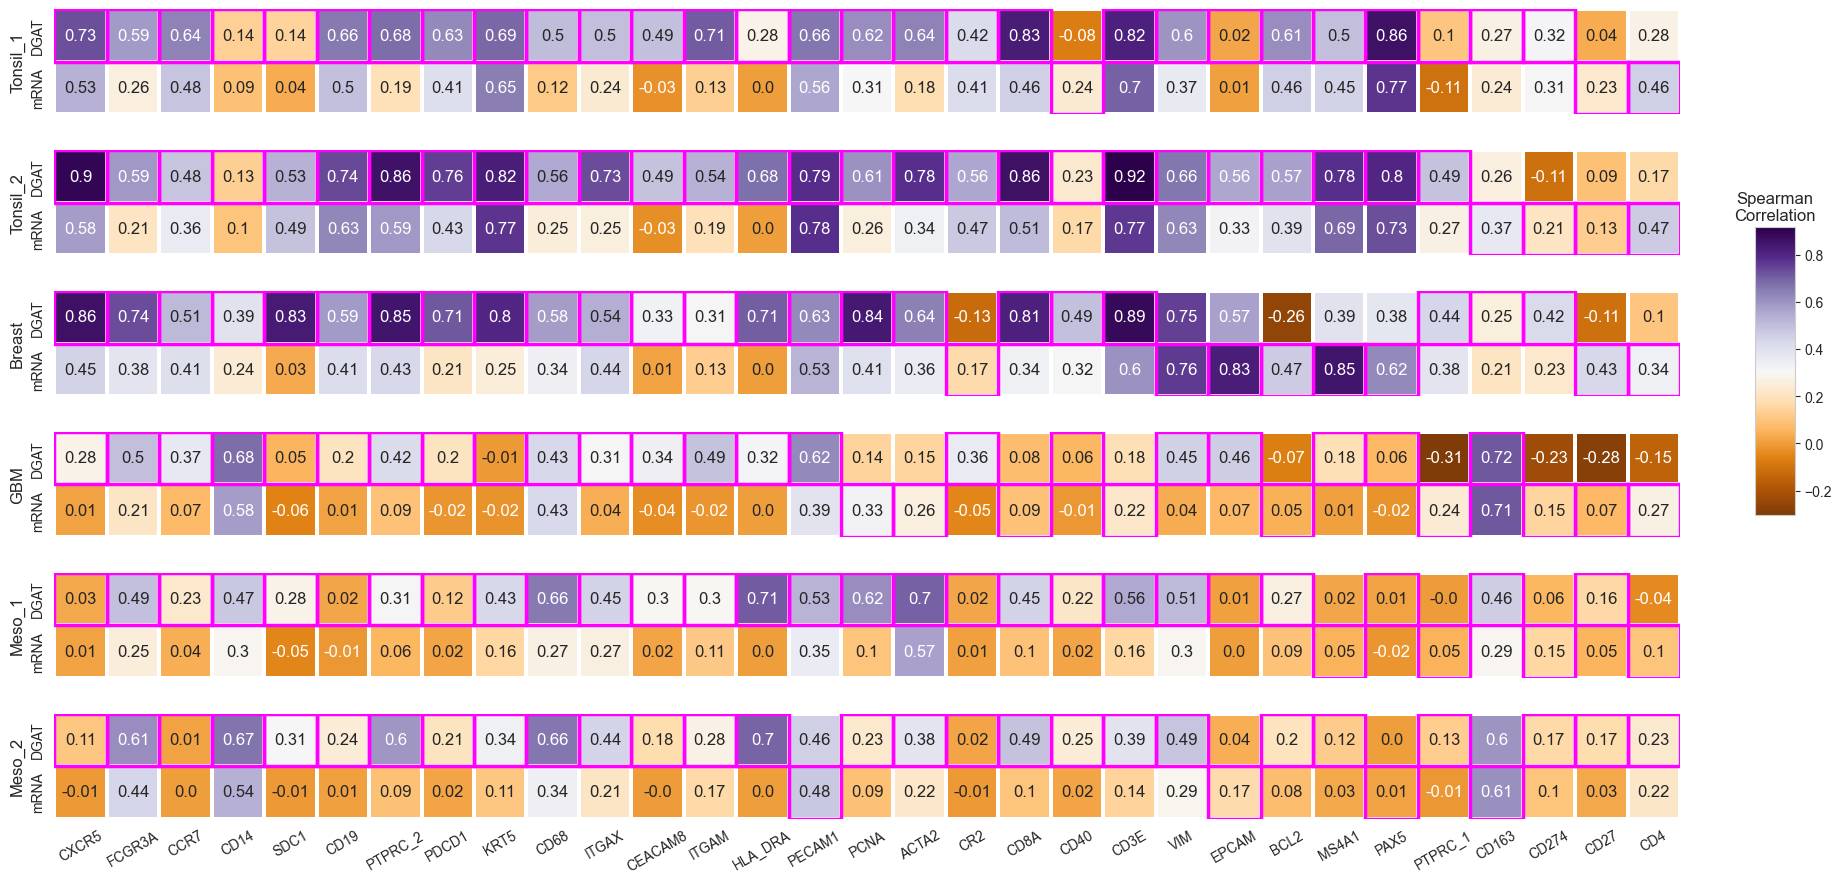

Saved: ./Figure_2A.pdf


In [6]:
def plot_samplewise_heatmaps_vertical(dgats_df, mrna_df, height_per_sample=1.6, width=20):

    better_counts = (dgats_df > mrna_df).sum(axis=0)
    protein_order = better_counts.sort_values(ascending=False).index.tolist()

    data_dict = {'DGAT': dgats_df, 'mRNA': mrna_df}
    sample_list = dgats_df.index.tolist()
    n_samples = len(sample_list)

    all_vals = np.concatenate([df.values.flatten() for df in data_dict.values()])
    vmin, vmax = np.nanmin(all_vals), np.nanmax(all_vals)
    fig, axes = plt.subplots(
        n_samples, 1,
        figsize=(width, height_per_sample * n_samples),
        squeeze=False,
        sharex=True
    )

    for idx, sample in enumerate(sample_list):
        ax = axes[idx][0]
        sample_df = pd.DataFrame({
            method: df.loc[sample]
            for method, df in data_dict.items()
        }).T
        sample_df = sample_df[protein_order]  

        heatmap_df = sample_df
        annot_df   = heatmap_df.round(2).astype(str)

        sns.heatmap(
            heatmap_df,
            cmap='PuOr',
            vmin=vmin, vmax=vmax,
            annot=annot_df, fmt='',
            annot_kws={'size': 12},
            cbar=False,
            linewidths=1.5,
            linecolor='white',
            square=True,
            ax=ax
        )

        for j, prot in enumerate(heatmap_df.columns):
            i = heatmap_df[prot].idxmax()
            row_idx = heatmap_df.index.get_loc(i)  
            rect = patches.Rectangle(
                (j, row_idx), 1, 1,
                linewidth=2.5,
                edgecolor='#FF00FF',
                facecolor='none'
            )
            ax.add_patch(rect)


        ax.set_ylabel(sample, fontsize=12)
        if idx == n_samples - 1:
            xticks = np.arange(heatmap_df.shape[1]) + 0.5
            ax.set_xticks(xticks)
            ax.set_xticklabels(heatmap_df.columns, rotation=30, ha='center')
        else:
            ax.tick_params(bottom=False, labelbottom=False)

    fig.subplots_adjust(right=0.85)
    cbar_ax = fig.add_axes([0.88, 0.4, 0.02, 0.3])
    norm = plt.Normalize(vmin=vmin, vmax=vmax)
    sm = cm.ScalarMappable(norm=norm, cmap='PuOr')
    sm.set_array([])
    cbar = fig.colorbar(sm, cax=cbar_ax)
    cbar.ax.set_title('Spearman\nCorrelation', pad=5, fontsize=12)

    plt.tight_layout(rect=[0, 0, 0.85, 0.96])
    out_file = './Figure_2A.pdf'
    fig.savefig(out_file, dpi=600)
    plt.show()

    print(f'Saved: {out_file}')
plot_samplewise_heatmaps_vertical(dgats_df, mrna_df)

### Figure 2B

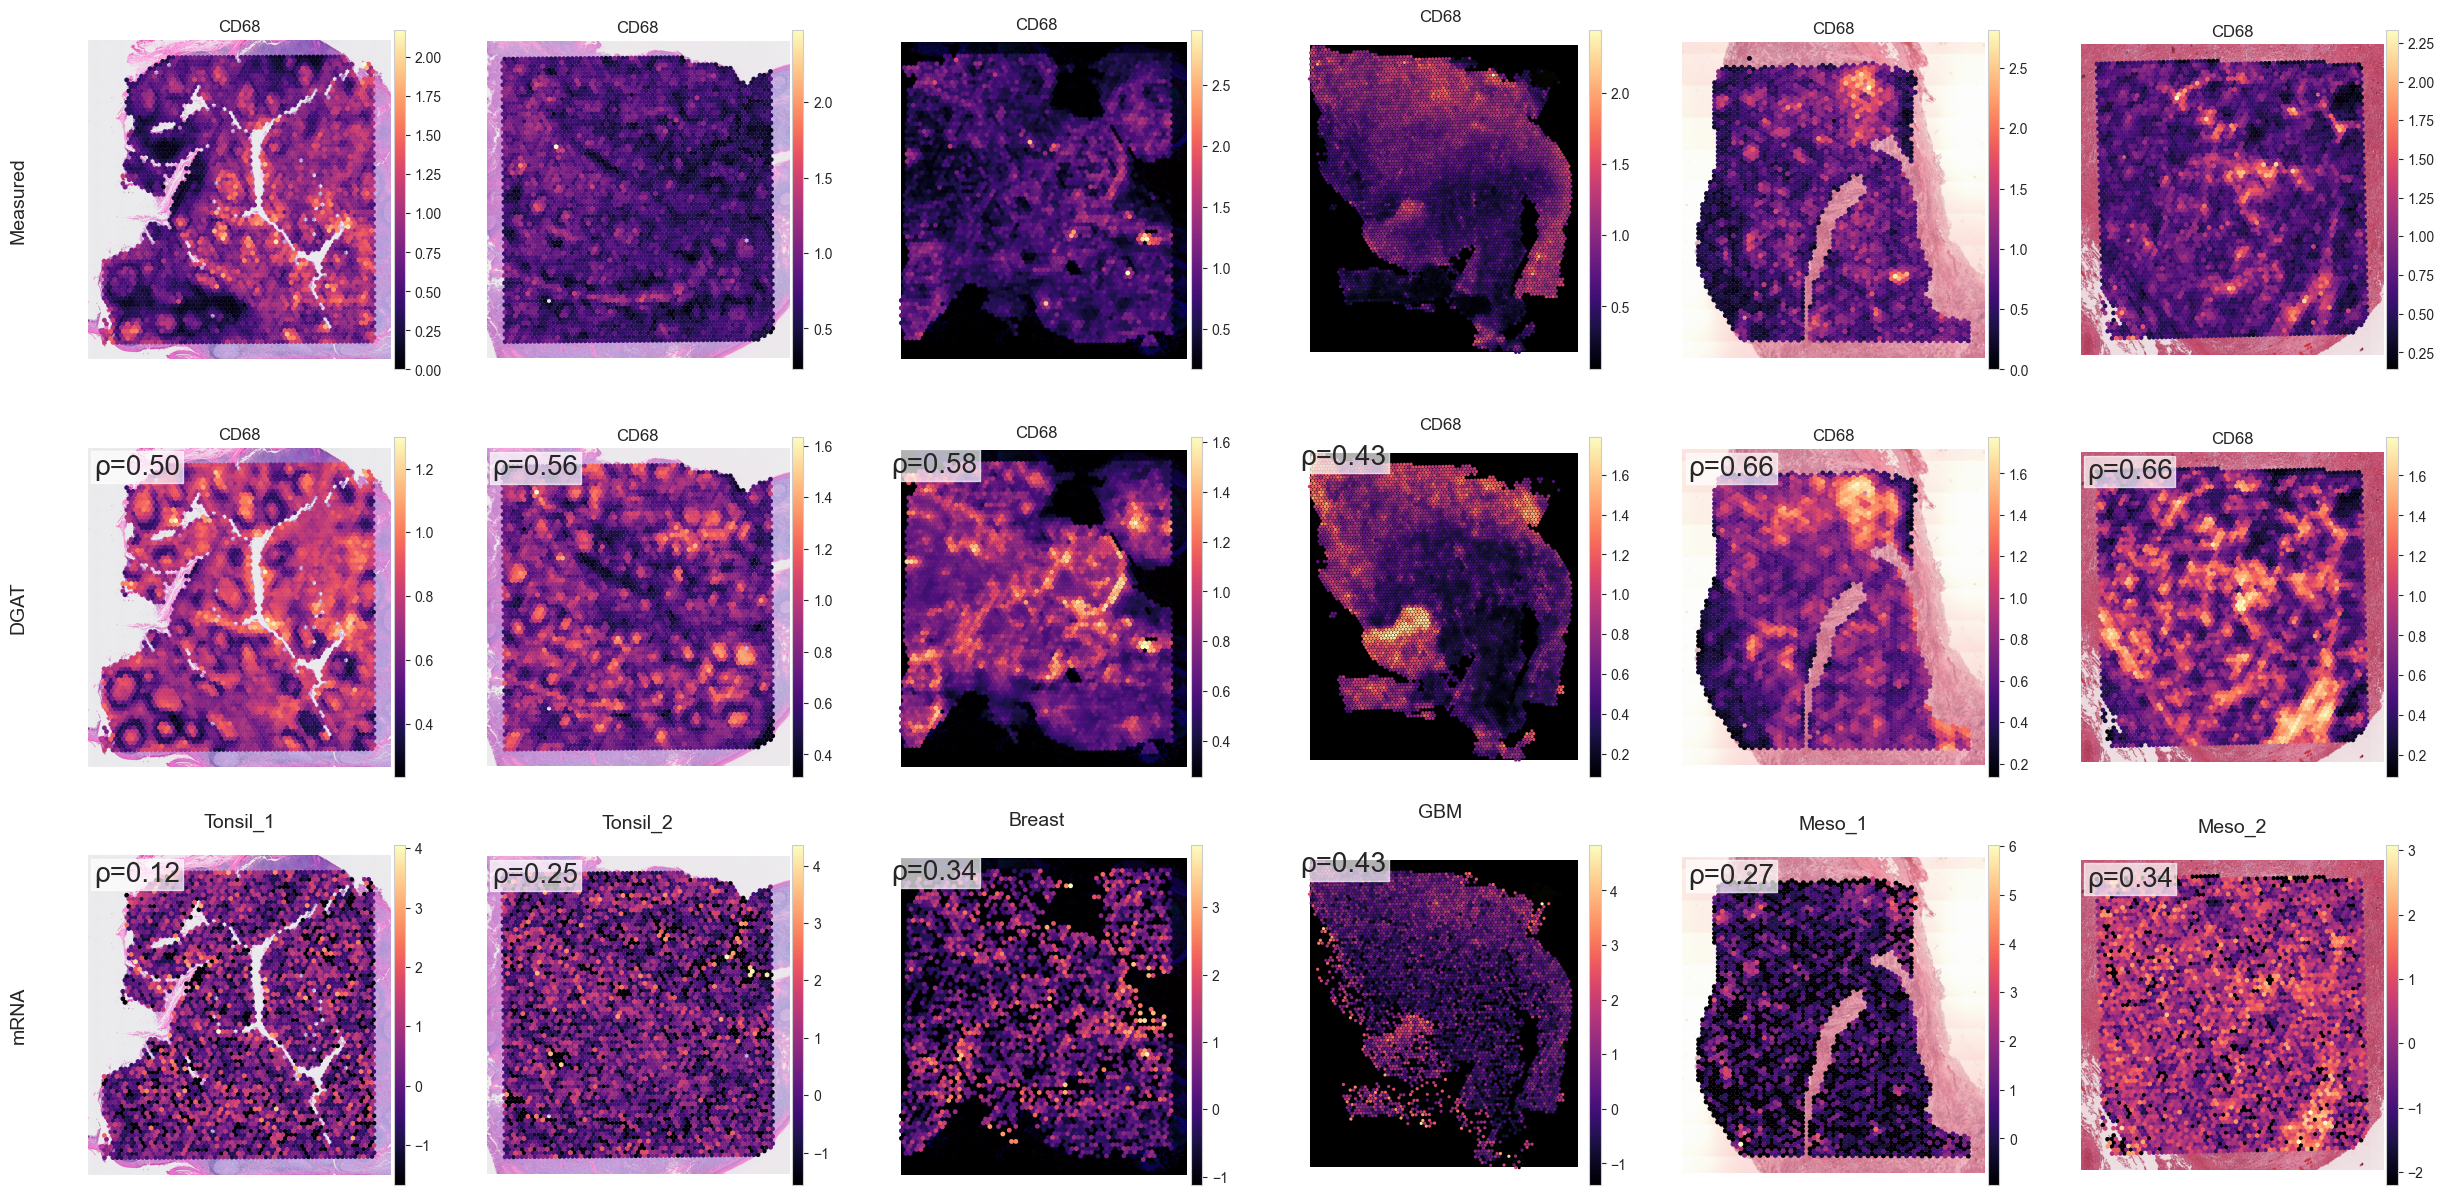

In [7]:



def plot_spatial_gene_comparison_all_new_test_fixed(
    gene: str,
    sample_list: list,
    pdata_list: list,
    pred_list: list,
    adata_list: list,
    cmap_protein: str = 'magma',
    cmap_pred: str    = 'magma',
    cmap_mrna: str    = 'magma',
    size: float = 1.6,
    save_path: str    = 'spatial_gene_comparison_fixed.png',
    dpi: int          = 100,
    title_fontsize: int = 14,
    show_corrs: bool = True,
    debug: bool = False,
    show_fig = False
):

    n = len(sample_list)
    fig = plt.figure(figsize=(5*n, 15))
    gs = fig.add_gridspec(3, n, height_ratios=[1,1,1], hspace=0.2)
    axes = np.empty((3, n), dtype=object)
    for i in range(3):
        for j in range(n):
            axes[i,j] = fig.add_subplot(gs[i, j])

    corr_pred = [0]*n
    corr_mrna = [0]*n

    def expr(mat, key):
        m = mat[:, key].X if hasattr(mat, 'X') else mat[key].values
        if sparse.issparse(m): m = m.toarray()
        return m.ravel()

    for j, s in enumerate(sample_list):
        e_meas = expr(pdata_list[j], gene)
        e_pred = expr(pred_list[j], gene)
        gm_key = gene if gene!='PTPRC_2' else 'PTPRC_1'
        e_mrna= expr(adata_list[j], gm_key)
        # corrs
        try: cp,_= spearmanr(e_meas,e_pred)
        except: cp=0
        try: cm,_= spearmanr(e_meas,e_mrna)
        except: cm=0
        corr_pred[j], corr_mrna[j] = cp, cm
        if debug: print(f"{s}: pred={cp:.2f}, mrna={cm:.2f}")
        mats = [pdata_list[j], pred_list[j], adata_list[j]]
        cmaps=[cmap_protein, cmap_pred, cmap_mrna]
        for i, ax in enumerate(axes[:, j]):
            mat = mats[i]
            key = gene
            if i==2 and gene=='PTPRC_2': key='PTPRC_1'
            sc.pl.spatial(mat, color=key, ax=ax, show=False,
                          frameon=False, size=size,
                          color_map=cmaps[i])
            if show_corrs and i in (1,2):
                val = corr_pred[j] if i==1 else corr_mrna[j]
                ax.text(0.02, 0.98, f"ρ={val:.2f}",
                        transform=ax.transAxes,
                        va='top', ha='left',
                        fontsize=20,
                        bbox=dict(facecolor='white', alpha=0.7, pad=2))
        axes[2,j].set_title(s, pad=20, fontsize=title_fontsize)

    labels = ['Measured','DGAT', 'mRNA']
    for i, lab in enumerate(labels):
        pos = axes[i,0].get_position()
        fig.text(
            pos.x0 - 0.02,
            pos.y0 + pos.height/2,
            lab,
            ha='right', va='center',
            fontsize=title_fontsize,
            rotation=90
        )

    # Save
    os.makedirs(os.path.dirname(save_path) or '.', exist_ok=True)
    fig.savefig(save_path, dpi=dpi, bbox_inches='tight')
    if show_fig:
        plt.show()
    else:
        plt.close(fig)


new_sample_list = ['Tonsil_1','Tonsil_2','Breast','GBM','Meso_1','Meso_2']
flag = False

plot_spatial_gene_comparison_all_new_test_fixed(
    gene='CD68',
    sample_list=new_sample_list,
    pdata_list=pdata_list,
    pred_list=pred_list,
    adata_list=adata_list,
    save_path=f'Spatial_Plot_All_Sample_new/CD68.pdf',
    dpi=600,
    show_fig =True
)

### Figure 3F

In [8]:
pred_LN_pdata = sc.read_h5ad(f'{pred_result_path}/DGAT_Predicted_ST/LN.h5ad')

In [9]:


def batch_analyze_and_plot_Tonsil_LN(
    adata_list: list,        # List[AnnData]
    method_names: list,      # List[str]
    genes: list[str],   
    save_dir: str,        
    cmap: str = 'magma',     
    point_size: float = 5,   
    title_fontsize: int = 16,
    dpi: int = 150           
) -> dict:

    os.makedirs(save_dir, exist_ok=True)
    n_methods = len(adata_list)
    n_genes = len(genes)

    def get_expr_vector(adata, gene_key):
        if gene_key in adata.var_names:
            mat = adata[:, gene_key].X
            if sparse.issparse(mat):
                mat = mat.toarray()
            return np.ravel(mat)
        else:
            try:
                return adata.to_df()[gene_key].values.ravel()
            except KeyError:
                raise KeyError(f"{adata} no gene {gene_key}")

    cluster_keys = ['germinal_center','pathology','pathology']

    raw_pvals = [ [] for _ in range(n_methods) ]
    for i, ad in enumerate(adata_list):
        key = cluster_keys[i]
        for gene in genes:

            gm = gene if gene != 'PTPRC_2' else 'PTPRC_1'
            expr = get_expr_vector(ad, gm)
            mask_gc = np.asarray(ad.obs[key] == "GC")
            mask_bg = ~mask_gc
            if mask_gc.sum() < 1 or mask_bg.sum() < 1:
                p = 1.0
            else:
                try:
                    p = mannwhitneyu(expr[mask_gc], expr[mask_bg], alternative='greater').pvalue
                except Exception:
                    p = 1.0
            raw_pvals[i].append(p)

    adj_pvals = []
    for i in range(n_methods):
        reject, adj = fdrcorrection(np.array(raw_pvals[i]), alpha=0.05, method='indep')
        adj_pvals.append(adj)

    pval_dict = {method_names[i]: {} for i in range(n_methods)}
    for i, method in enumerate(method_names):
        for j, gene in enumerate(genes):

                
            pval_dict[method][gene] = {
                'p_raw': float(raw_pvals[i][j]),
                'p_adj': float(adj_pvals[i][j])
            }

    for j, gene in enumerate(genes):
        fig, axes = plt.subplots(
            n_methods, 1,
            figsize=(5, 4 * n_methods),
            constrained_layout=True
        )
        axes = np.atleast_1d(axes).flatten()
        for i, (ad, method) in enumerate(zip(adata_list, method_names)):
            ax = axes[i]
            gm = gene if gene != 'PTPRC_2' else 'PTPRC_1'
            sc.pl.spatial(
                ad,
                color=gm,
                show=False,
                frameon=False,
                ax=ax,
                size=point_size,
                title='',
                color_map=cmap
            )
            p_adj = pval_dict[method][gene]['p_adj']
            ax.set_title(f"adj. p = {p_adj:.2e}", fontsize=title_fontsize)

            try:
                if i == 0:
                    points, edges = find_edges(ad)
                else:
                    points, edges = find_edges(ad, cluster_name='pathology')
                if edges and points is not None:
                    for ii, jj in edges:
                        ax.plot(
                            points[[ii, jj], 0],
                            points[[ii, jj], 1],
                            color='k',
                            linewidth=0.9
                        )
            except NameError:
                pass

        out_path = os.path.join(save_dir, f"{gene}.pdf")
        fig.savefig(out_path, dpi=dpi, bbox_inches='tight')
        plt.show()

    return pval_dict

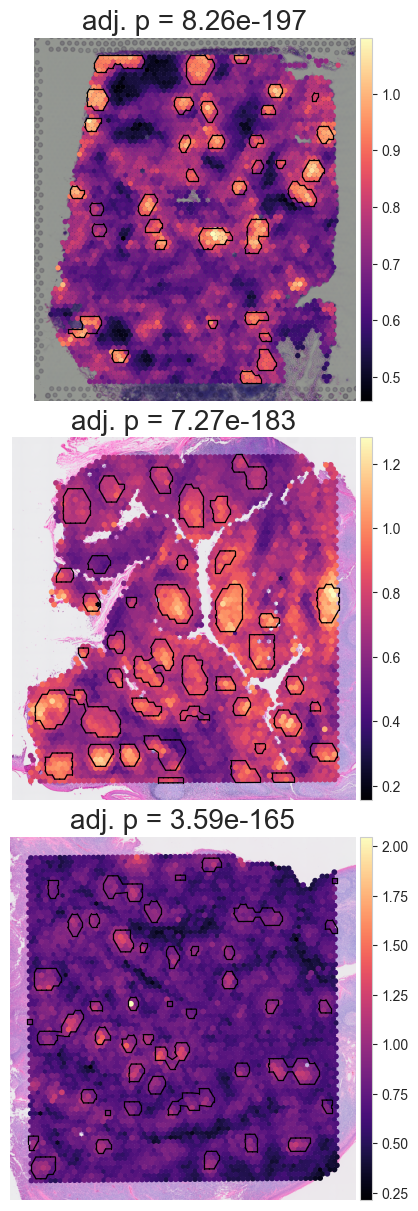

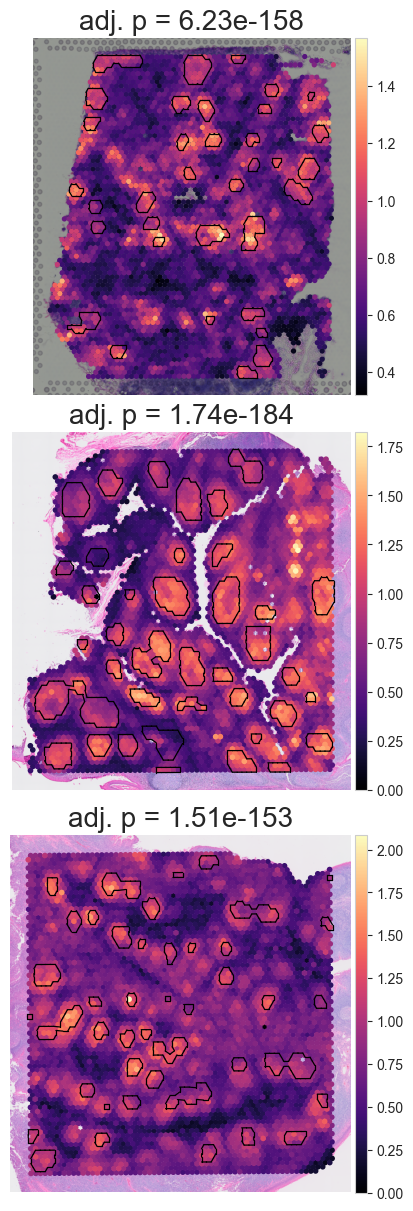

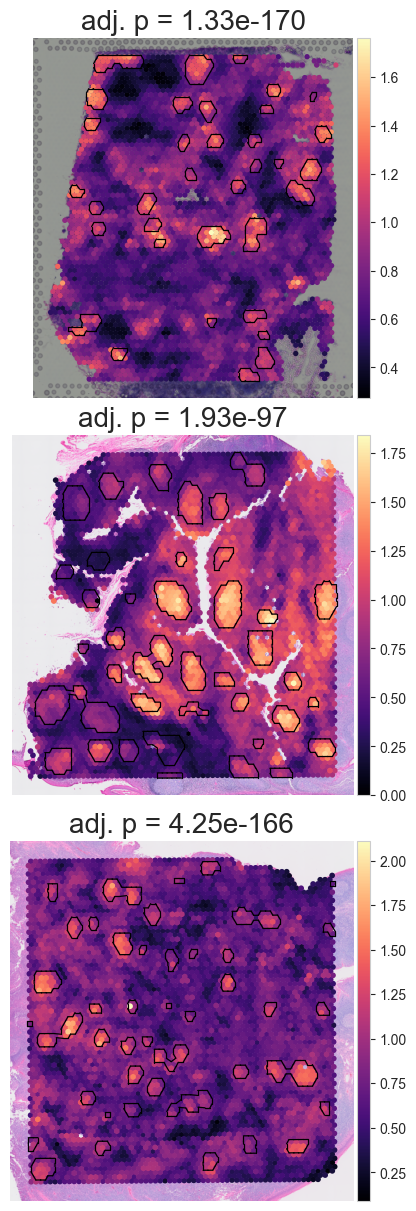

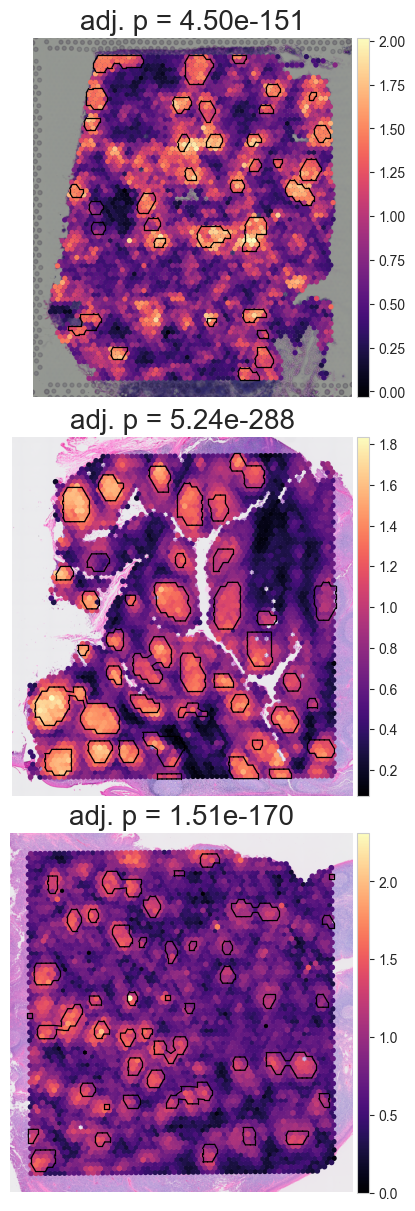

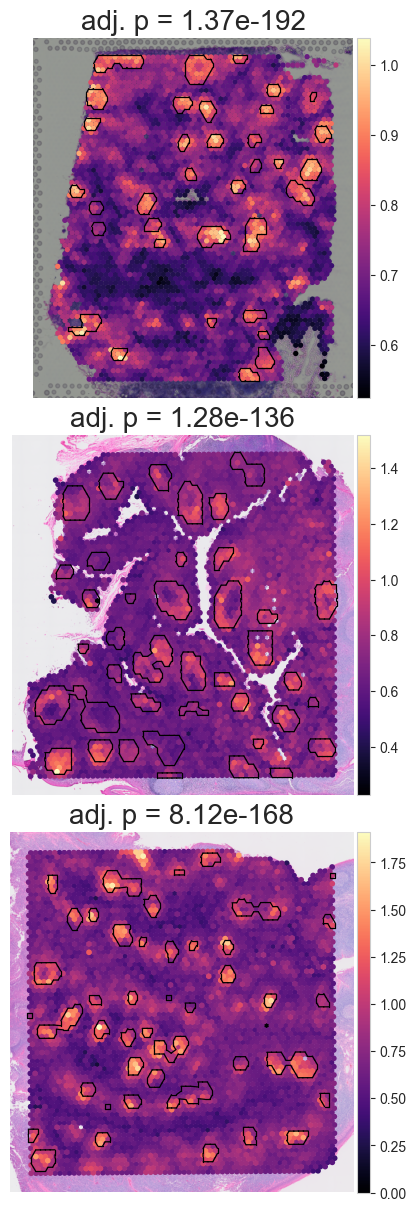

In [10]:
genes = ['CD19', 'CXCR5','MS4A1','PAX5','PDCD1'] 
pvals = batch_analyze_and_plot_Tonsil_LN(
    adata_list=[pred_LN_pdata, pdata_list[0], pdata_list[1]],
    method_names=['Predicted_Protein_LN', 'Protein_Tonsil1', 'Protein_Tonsil2'],
    genes=genes,
    save_dir='Tonsil_LN_Spatial_all_new',
    cmap='magma',
    point_size=1.7,
    title_fontsize=20,
    dpi=200
)